In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from typing import Callable
from statistics import median
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from itertools import product

In [3]:
from scipy.constants import golden_ratio

In [4]:
# Загружаем данные, добавляем столбец признаков, для того чтобы обучать коэффициент сдвига
df = pd.read_csv("data/diabetes_dataset.csv", delimiter=",", decimal=".")
not_normalized_features = df.drop(columns=['Outcome'])
F = (not_normalized_features - not_normalized_features.mean()) / not_normalized_features.std()
F["bias"] = 1

In [5]:
F

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,bias
0,0.639530,0.847771,0.149543,0.906679,-0.692439,0.203880,0.468187,1.425067,1
1,-0.844335,-1.122665,-0.160441,0.530556,-0.692439,-0.683976,-0.364823,-0.190548,1
2,1.233077,1.942458,-0.263769,-1.287373,-0.692439,-1.102537,0.604004,-0.105515,1
3,-0.844335,-0.997558,-0.160441,0.154433,0.123221,-0.493721,-0.920163,-1.040871,1
4,-1.141108,0.503727,-1.503707,0.906679,0.765337,1.408828,5.481337,-0.020483,1
...,...,...,...,...,...,...,...,...,...
763,1.826623,-0.622237,0.356200,1.721613,0.869464,0.115094,-0.908090,2.530487,1
764,-0.547562,0.034575,0.046215,0.405181,-0.692439,0.609757,-0.398023,-0.530677,1
765,0.342757,0.003299,0.149543,0.154433,0.279412,-0.734711,-0.684747,-0.275580,1
766,-0.844335,0.159683,-0.470426,-1.287373,-0.692439,-0.240048,-0.370859,1.169970,1


In [6]:
F = F.to_numpy()

In [7]:
target = df[['Outcome']].to_numpy().squeeze(-1)

In [7]:
np.count_nonzero(target) / target.shape[0]

0.3489583333333333

In [8]:
# разбиваем данные на тестовую и тренировочную части
F_train, F_test, y_train, y_test = train_test_split(F, target, test_size=0.2, random_state=52,
                                                    stratify=target)

In [9]:
np.count_nonzero(y_train) / y_train.shape[0]

0.3485342019543974

In [9]:
def modify_targets(targets):
    return targets + (-1) * (targets == 0)

In [10]:
# реализация линейной регрессии
def linear_regression(data_train, target_train, r=1):
    U, D, Vh = np.linalg.svd(data_train, full_matrices=False)
    D = np.diag(D)
    regulated_thetta = Vh.T @ np.linalg.inv(D ** 2 + r[None] * np.eye(data_train.shape[1])) @ D @ U.T @ target_train
    return regulated_thetta

In [11]:
# реализация классификации через линейную регрессию
def linear_classification_from_regression(linear_regressor, data_train, target_train):
    regul_without_bias = np.ones((data_train.shape[1],))
    regul_without_bias[-1] = 0
    return linear_regressor(data_train, modify_targets(target_train), regul_without_bias)


In [12]:
# предсказание самого наивного классификатора
classificator_pred = np.sign(F_test @ linear_classification_from_regression(linear_regression, F_train, y_train))
lin_reg_score = f1_score(classificator_pred, modify_targets(y_test))

In [11]:
lin_reg_score

np.float64(0.6595744680851063)

In [13]:
# класс для эмпирического риска
class Custom_error_function:
    def __init__(self, name, func, grad):
        self.name = name
        self.func = func
        self.grad = grad

    def __call__(self, *args, **kwargs):
        return self.func(*args, **kwargs)

    def cacl_grad(self, *args, **kwargs):
        return self.grad(*args, **kwargs)

    def __str__(self):
        return self.name

In [14]:
# функция линейного классификатора с использованием градиентного спуска
def linear_classification(data_train: np.ndarray, target_train: np.ndarray, error_function: Custom_error_function,
                          descent_step: Callable, bias=True, elastic_net=True, l1_coeff=0, l2_coeff=0,
                          iteration_amount=1000, show_results=False, data_test=None,
                          target_test=None):
    result = []
    f1_scores = []
    boundary = 1 / (2 * data_train.shape[0])
    thetta = np.random.uniform(-boundary, boundary, data_train.shape[1])
    if bias:
        thetta[-1] = 0
    for k in range(iteration_amount):
        func_grad = error_function.cacl_grad(thetta, data_train, target_train)
        if show_results:
            result.append(error_function(data_train @ thetta * target_train))
            if k % 50 == 0:
                f1_scores.append(f1_score(modify_targets(target_test), np.sign(data_test @ thetta)))
        l1_vect, l2_vect = np.ones((thetta.shape[0],)), np.ones((thetta.shape[0],))
        if bias:
            l1_vect[-1], l2_vect[-1] = 0, 0
        l1_vect *= l1_coeff
        l2_vect *= l2_coeff
        if elastic_net:
            func_grad += l2_vect * thetta + l1_vect * np.sign(thetta)
        func = lambda lr: error_function(data_train @ (thetta - lr * func_grad) * target_train)
        step = descent_step(func, k)
        thetta -= step * func_grad
    return thetta, result, f1_scores

In [15]:
def piecewise_linear_grad(thetta, data_train: np.ndarray, target_train: np.ndarray):
    func_args = data_train * target_train[..., None]
    predicts = ((data_train @ thetta) * target_train <= 0)[..., None]
    return np.sum((-1) * (func_args * predicts), axis=0)


piecewise_linear_function = Custom_error_function("piecewise linear",
                                                  lambda x: np.sum(np.clip(-x, a_min=0, a_max=None)),
                                                  piecewise_linear_grad)

In [16]:
def logarifmic_grad(thetta, data_train: np.ndarray, target_train: np.ndarray):
    func_args = -data_train * target_train[..., None]
    predicts = data_train @ thetta * target_train
    return np.sum((np.exp(-predicts) / (1 + np.exp(-predicts)))[..., None] * func_args, axis=0)


logarifmic_function = Custom_error_function("logarifmic",
                                            lambda x: np.sum(np.log(1 + np.exp(-x))),
                                            logarifmic_grad)

In [17]:
def exponential_grad(thetta, data_train: np.ndarray, target_train: np.ndarray):
    func_args = -data_train * target_train[..., None]
    predicts = (data_train @ thetta) * target_train
    return np.sum(np.exp(-predicts)[..., None] * func_args, axis=0)


exponential_function = Custom_error_function("exponential",
                                             lambda x: np.sum(np.exp(-x)),
                                             exponential_grad)

In [395]:
error_functions = [piecewise_linear_function, logarifmic_function, exponential_function]

In [396]:
lrs = [1, 0.1, 0.01, 0.001, 1e-4]

In [18]:
class Constant_step:
    def __init__(self, step_size: float):
        self.step_size = step_size
    
    def __str__(self):
        return f"Constant_step: {self.step_size}"

    def __call__(self, *args, **kwargs):
        return self.step_size

In [19]:
def iteration_step(_, k, **__):
    return 1 / np.sqrt(1 + k)

In [20]:
def golden_ratio_step(function, _, left=0, right=1,
                      stop_delta=1e-5):
    x1 = left + (right - left) / golden_ratio ** 2
    x2 = left + (right - left) / golden_ratio
    x1_val = function(x1)
    x2_val = function(x2)
    while (right - left) > stop_delta:
        if x1_val <= x2_val:
            right = x2
            x2 = x1
            x1 = left + (right - left) / golden_ratio ** 2
            x1_val = function(x1)
        else:
            left = x1
            x1 = x2
            x2 = left + (right - left) / golden_ratio
            x2_val = function(x2)
    return (left + right) / 2

In [400]:
gradient_descent_steps = [Constant_step(lr) for lr in lrs] + [iteration_step, golden_ratio_step]

In [20]:
# ищем лучшие гиперпараметры
best_score = -1
params = None
best_thetta = None
for p in tqdm(
        list(product(error_functions, gradient_descent_steps, [True, False], [0.01, 0.1, 1, 10], [0.01, 0.1, 1, 10]))):
    err_f, step_f, elastic_net, l1_c, l2_c = p
    found_thetta, *_ = linear_classification(F_train, modify_targets(y_train), err_f, step_f,
                                             elastic_net=elastic_net, l1_coeff=l1_c, l2_coeff=l2_c)
    try:
        score = f1_score(modify_targets(y_train), np.sign(F_train @ found_thetta))
    except ValueError:
        continue
    if score > best_score:
        params = (err_f, step_f, elastic_net, l1_c, l2_c)
        best_score = score
        best_thetta = found_thetta
print(best_score)
print(*[str(p) for p in params])

NameError: name 'error_functions' is not defined

In [21]:
# собираем данные для построения графиков
best_thetta, lin_cls_path, f1_score_lin_cls = linear_classification(F_train, modify_targets(y_train),
                                                                    logarifmic_function, Constant_step(0.01),
                                                                    l1_coeff=0.01, l2_coeff=0.01, show_results=True,
                                                                    data_test=F_test,
                                                                    target_test=modify_targets(y_test))

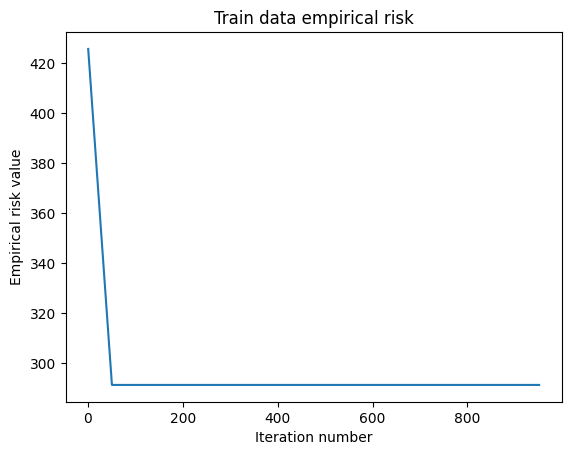

In [22]:
plt.plot(np.arange(1, 1000)[::50], lin_cls_path[::50])
plt.xlabel('Iteration number')
plt.ylabel('Empirical risk value')
plt.title("Train data empirical risk")
plt.show()

In [23]:
f1_score(modify_targets(y_test), np.sign(F_test @ best_thetta))

np.float64(0.6597938144329897)

In [24]:
modified_targets = modify_targets(y_train)

In [25]:
# реализация метода опорных векторов
def svm_method(data_train, target_train, kernel_f, C, iteration_amount=1000, show_result=False,
               data_test=None, target_test=None):
    result = []
    f1_score_path = []
    modified_targets = modify_targets(target_train)
    pairwise_product = np.einsum("ij,kj->ik", data_train, data_train)
    pairwise_kerneled = kernel_f(pairwise_product) * modified_targets[None] * modified_targets[..., None]

    def svm_loss_grad(alphas, kernel_pairs: np.ndarray):
        ans = kernel_pairs * alphas[None]
        return ans.sum(axis=1) - 1

    def svm_err_func(alphas, kernel_pairs: np.ndarray):
        ans = alphas[..., None] * kernel_pairs * alphas[None]
        return ans.sum() / 2 - alphas.sum()

    def count_bias(alphas):
        supports = []
        for i in range(len(alphas)):
            if 0 < alphas[i] < C:
                supports.append(
                    data_train[i] @ np.sum(alphas[..., None] * modified_targets[..., None] * data_train, axis=0) -
                    modified_targets[i])
        return median(supports) if supports else 0

    svm_function = Custom_error_function("svm",
                                         svm_err_func,
                                         svm_loss_grad)
    alphas = np.zeros((data_train.shape[0],))
    for k in range(iteration_amount):
        if show_result:
            result.append(svm_function(alphas, pairwise_kerneled))
            if k % 50 == 0:
                path_pred = np.sign(
                    np.sum(np.einsum("ij,kj->ki", data_train, data_test) * target_train[None] * alphas[None],
                           axis=1) - count_bias(alphas))
                f1_score_path.append(f1_score(path_pred + (path_pred == 0) * -1, modify_targets(target_test)))
        func_grad = svm_function.cacl_grad(alphas, pairwise_kerneled)
        func = lambda lr: svm_function(alphas - lr * func_grad, pairwise_kerneled)
        step = golden_ratio_step(func, k)
        alphas -= step * func_grad
        alphas = np.clip(alphas, a_min=0, a_max=C)
        alphas_and_targets = alphas * modified_targets
        positive_alph = ((alphas_and_targets >= 0) * alphas)
        negative_alph = ((alphas_and_targets < 0) * alphas)
        coeff = positive_alph.sum() / negative_alph.sum()
        alphas *= (coeff * (alphas_and_targets < 0) + (alphas_and_targets > 0))
    w_0 = count_bias(alphas)
    return alphas, w_0, result, f1_score_path

In [408]:
Cs = [0.01, 0.1, 1, 10]

In [26]:
# класс ядра (взят из прошлой лабы)
class Customkernel:
    def __init__(self, name, func):
        self.name = name
        self.func = func

    def __call__(self, *args, **kwargs):
        return self.func(*args)

    def __str__(self):
        return self.name

In [27]:
squared = Customkernel("squared", lambda x: x * x)
monomial = Customkernel("monomial", lambda x: (x + 1) ** 4)
sigmoid = Customkernel("sigmoid", lambda x: 1 / (1 + np.exp(-x)))
kernels = [squared, monomial, sigmoid]

In [411]:
# поиск лучших гиперпараметров
best_score = -1
params = None
for p in tqdm(list(product(kernels, Cs))):
    kern, c = p
    alphas_fitted, bias, *_ = svm_method(F_train[..., :-1], modify_targets(y_train), kern, c)
    pred = np.sign(np.sum(
        np.einsum("ij,kj->ki", F_train[..., :-1], F_train[..., :-1]) * modified_targets[None] * alphas_fitted[None],
        axis=1) - bias)
    score = f1_score(pred, modify_targets(y_train))
    if score > best_score:
        best_score = score
        params = (kern, c)
print(best_score)
print(*[str(p) for p in params])

  0%|          | 0/12 [00:00<?, ?it/s]

0.6492374727668845
sigmoid 0.01


In [28]:
# собираем данные для построения графиков
alphas_fitted, bias, svm_path, f1_score_svm = svm_method(F_train[..., :-1], modify_targets(y_train), sigmoid, 0.01,
                                                         show_result=True, data_test=F_test[..., :-1],
                                                         target_test=modify_targets(y_test))

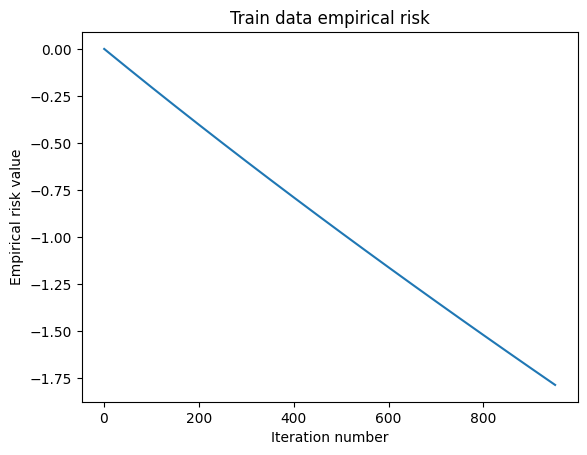

In [29]:
plt.plot(np.arange(1, 1000)[::50], svm_path[::50])
plt.xlabel('Iteration number')
plt.ylabel('Empirical risk value')
plt.title("Train data empirical risk")
plt.show()

In [30]:
pred = np.sign(
    np.sum(np.einsum("ij,kj->ki", F_train[..., :-1], F_test[..., :-1]) * modified_targets[None] * alphas_fitted[None],
           axis=1) - bias)
f1_score(pred, modify_targets(y_test))

np.float64(0.6608695652173913)

In [415]:
# перебираем разные разбиения на test и train
f1_scores_svm = []
f1_scores_lin_cls = []
for test_size in tqdm([0.1, 0.2, 0.3, 0.5]):
    d_train, d_test, y_train, y_test = train_test_split(F, target, test_size=test_size, random_state=52,
                                                        stratify=target)
    *_, f1_score_svm_looped = svm_method(d_train[..., :-1], modify_targets(y_train), sigmoid, 0.01, show_result=True,
                                         data_test=d_test[..., :-1], target_test=modify_targets(y_test))
    f1_scores_svm.append(f1_score_svm_looped)
    *_, f1_score_lin_cls_looped = linear_classification(d_train, modify_targets(y_train), logarifmic_function,
                                                        Constant_step(0.01), l1_coeff=0.01, l2_coeff=0.01,
                                                        show_results=True,
                                                        data_test=d_test, target_test=modify_targets(y_test))
    f1_scores_lin_cls.append(f1_score_lin_cls_looped)

  0%|          | 0/4 [00:00<?, ?it/s]

In [32]:
f1_scores_svm_arr = np.array(f1_scores_svm)
f1_svm_mins = f1_scores_svm_arr.min(axis=0)
f1_svm_maxs = f1_scores_svm_arr.max(axis=0)

In [33]:
f1_scores_lin_cls_arr = np.array(f1_scores_lin_cls)
f1_lin_mins = f1_scores_lin_cls_arr.min(axis=0)
f1_lin_maxs = f1_scores_lin_cls_arr.max(axis=0)

ValueError: zero-size array to reduction operation minimum which has no identity

In [30]:
plt.plot(np.arange(1, 1000)[::50], f1_score_svm, label="F1 score SVM")
plt.fill_between(np.arange(1, 1000)[::50], f1_svm_mins, f1_svm_maxs, alpha=.2)
plt.plot(np.arange(1, 1000)[::50], f1_score_lin_cls, label="F1 score linear classification")
plt.fill_between(np.arange(1, 1000)[::50], f1_lin_mins, f1_lin_maxs, alpha=.2)
plt.plot(np.arange(1, 1000)[::50], np.ones((20,)) * lin_reg_score, "--", label="F1 score linear regression")
plt.xlabel('Iteration number')
plt.ylabel("F1 score")
plt.legend()
plt.show()

In [35]:
# перебираем разные разбиения на test и train
f1_scores_svm = []
f1_scores_lin_cls = []
for seed in tqdm(np.arange(50, 55)):
    d_train, d_test, y_train, y_test = train_test_split(F, target, test_size=0.2, random_state=seed,
                                                        stratify=target)
    *_, f1_score_svm_looped = svm_method(d_train[..., :-1], modify_targets(y_train), sigmoid, 0.01, show_result=True,
                                         data_test=d_test[..., :-1], target_test=modify_targets(y_test))
    f1_scores_svm.append(f1_score_svm_looped)
    *_, f1_score_lin_cls_looped = linear_classification(d_train, modify_targets(y_train), logarifmic_function,
                                                        Constant_step(0.01), l1_coeff=0.01, l2_coeff=0.01,
                                                        show_results=True,
                                                        data_test=d_test, target_test=modify_targets(y_test))
    f1_scores_lin_cls.append(f1_score_lin_cls_looped)

  0%|          | 0/5 [00:00<?, ?it/s]

In [34]:
f1_scores_lin_cls

[]